# ASHRAE with fast.ai, Part 3: Inference

This kernel leverages the convenient fast.ai API to prepare the test set for inference in just a few lines of code.

In order to combine the large size of the ASHRAE dataset and the overhead of fast.ai's objects with the limited memory of Kaggle sessions, this kernel is part of a series which further includes:

- https://www.kaggle.com/michelezoccali/ashrae-with-fast-ai-part-1 (preprocessing)
- https://www.kaggle.com/michelezoccali/ashrae-with-fast-ai-part-2 (training)

# Imports

In [1]:
import os
import gc
import sys
import pickle

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from fastai.tabular.all import *

# plotting
import seaborn as sns

In [2]:
data_path = '../input/ashrae-with-fast-ai-part-1/'
model_path = '../input/ashrae-with-fast-ai-part-2/'

for path in [data_path, model_path]:
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            print(os.path.join(dirname, filename))

../input/ashrae-with-fast-ai-part-1/__results__.html
../input/ashrae-with-fast-ai-part-1/preprocessing_no_lag.h5
../input/ashrae-with-fast-ai-part-1/__resultx__.html
../input/ashrae-with-fast-ai-part-1/__notebook__.ipynb
../input/ashrae-with-fast-ai-part-1/__output__.json
../input/ashrae-with-fast-ai-part-1/custom.css
../input/ashrae-with-fast-ai-part-2/__results__.html
../input/ashrae-with-fast-ai-part-2/tabular_nn.pickle
../input/ashrae-with-fast-ai-part-2/__notebook__.ipynb
../input/ashrae-with-fast-ai-part-2/__output__.json
../input/ashrae-with-fast-ai-part-2/custom.css
../input/ashrae-with-fast-ai-part-2/__results___files/__results___26_2.png


# Prepare test dataset

In [3]:
#%%time
X_test = pd.read_hdf(data_path + 'preprocessing_no_lag.h5', 'test')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   row_id             uint32 
 1   building_id        uint16 
 2   meter              uint8  
 3   site_id            uint8  
 4   primary_use        uint8  
 5   square_feet        uint32 
 6   year_built         float32
 7   floor_count        float32
 8   air_temperature    float32
 9   cloud_coverage     float32
 10  dew_temperature    float32
 11  precip_depth_1_hr  float32
 12  hour               uint8  
 13  weekday            uint8  
dtypes: float32(6), uint16(1), uint32(2), uint8(5)
memory usage: 1.8 GB


In [4]:
row_ids = X_test.row_id # for submission file
X_test = X_test.drop(columns='row_id')

gc.collect()

0

In [5]:
procs_nn = [Categorify, Normalize]
cont = ['building_id','square_feet','year_built','floor_count','air_temperature','cloud_coverage',
       'dew_temperature','precip_depth_1_hr']
cat = ['meter','site_id','primary_use','hour','weekday']

Let's create a TabularPandas instance with the same transforms of the training set.

In [6]:
test = TabularPandas(X_test, procs_nn, cat, cont, inplace=True, reduce_memory=True)

del X_test, procs_nn, cat, cont
gc.collect()

52

We can now load our trained neural network back in...

In [7]:
with open(f'{model_path}/tabular_nn.pickle', mode='rb') as f:
    learn = pickle.load(f)

...and predict with it.

In [8]:
n_iterations = 30
batch_size = len(test) // n_iterations

preds = []
for i in tqdm(range(n_iterations)):
    start = i * batch_size
    test_batch = test.iloc[start:start + batch_size]
    test_dl = TabDataLoader(test_batch, bs=batch_size, shuffle=False, drop_last=False)
    
    del test_batch; gc.collect()
    
    batch_preds, _ = learn.get_preds(dl=test_dl)
    batch_preds = to_np(batch_preds.squeeze())
    preds.extend(np.expm1(batch_preds))
    
    del test_dl, batch_preds; gc.collect()

  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:172: UserWarning: Using a target size (torch.Size([1389920, 0])) that is different to the input size (torch.Size([1389920, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss_grad = self.loss_func(self.pred, *self.yb)


At last, we can save our predictions (clipped at 0 on the left as negative meter readings do not make much sense) and inspect their distribution.

In [9]:
submission = pd.DataFrame({'row_id':row_ids, 'meter_reading':np.clip(preds, 0, a_max=None)})
submission.to_csv('submission.csv', index=False)

del preds

(41697600,)


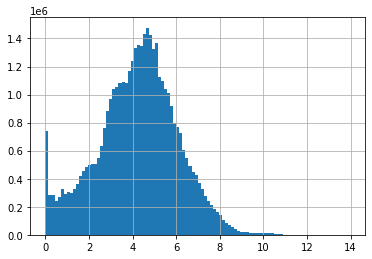

In [10]:
logs = np.log1p(submission.meter_reading)
print(logs.shape)
np.log1p(submission.meter_reading).hist(bins=100);

In [11]:
#sns.displot(logs);

In [12]:
submission.meter_reading.min(), submission.meter_reading.max(), submission.meter_reading.mean()

(3.9269902e-12, 1157407.2, 421.07315)

And now we are done!

If anyone has any tips regarding a better management of memory resources (with or without fast.ai classes), so as to fit all of this in a single kernel for instance, they'd be greatly appreciated! 😉